# Mutual Influence AI — Results Analysis (Publication Version)
*Prepared: 2025-11-03*

This notebook is a **documentation-only** revision of the original analysis. **All code cells remain unchanged**; additional Markdown cells provide:
- an abstract and scope,
- clear instructions for data input and execution,
- environment and reproducibility notes,
- a column dictionary for the expected `results.csv`,
- figure list with captions,
- licensing and citation guidance.

> **Note:** If you re-run the notebook, outputs may differ if the upstream data or random seeds change. For artifact stability in peer review, consider freezing package versions and providing the exact `results.csv` used.


## Abstract
This notebook analyzes results from **Mutual Influence AI** experiments. It loads a consolidated CSV file (`results.csv`), computes summary statistics (agreement, approval-at-round-1, sensitivity across hyperparameters), and renders publication-ready plots. The goal is to quantify how an *influence* mechanism affects cross-critic agreement, revision depth, and robustness under adversarial settings.


## Scope & Intended Use
- **Audience:** researchers/practitioners evaluating multi-agent critique systems and influence mechanisms.
- **Inputs:** a single CSV produced by your evaluation pipeline (e.g., `run_grid.py`).
- **Outputs:** tables/plots suitable for inclusion in papers or technical reports.
- **Non-goals:** data collection, model training, or hyperparameter search (handled elsewhere).


## How to Run
1. Place the aggregated results file at the notebook root: `./results.csv`.
2. Start Jupyter: `jupyter lab` or `jupyter notebook`.
3. Run cells *top-to-bottom*.
4. If plots look empty, confirm the expected columns (see **Data Schema** below) and the path to `results.csv`.

**Tip:** For deterministic figures, set a fixed random seed in your data pipeline and avoid non-deterministic sampling in upstream scripts.


## Environment
- Python ≥ 3.10
- pandas, numpy, matplotlib, seaborn (exact versions can be pinned for reproducibility)
- Jupyter Lab/Notebook

If you plan to publish artifacts, consider exporting `pip freeze > requirements.txt` from your working environment.


## Data Schema (`results.csv`)
The notebook expects the consolidated CSV to include the following columns (rename if yours differ):
- `run_id`: unique identifier of an evaluation run.
- `mode`: experimental condition (e.g., `baseline`, `influence`, `adversarial`).
- `alpha`, `beta`: influence-related hyperparameters (floats).
- `agreement`: cross-critic agreement metric for the run (float in [0,1]).
- `approval_round1`: indicator or rate of approval at round 1 (float or 0/1).
- `revision_depth`: number of editing/revision steps between rounds (integer or float).
- `seed`: random seed used for this run (integer).
- `timestamp`: ISO datetime of the run (optional).

If your CSV uses different names, either adapt the mapping cell in the notebook (recommended in a separate copy) or alias your columns beforehand.


## Figure List & Captions
- **Fig. 1 – Agreement (baseline → influence)**: Scatter plot comparing mean agreement per run; points on/above the diagonal indicate improvement under influence.
- **Fig. 2 – Approval@Round1**: Bar plot of approval rate for the first critic response, broken down by condition.
- **Fig. 3 – Sensitivity Heatmap (α × β)**: Heatmap of mean agreement across hyperparameters; cooler/warmer regions indicate worse/better agreement.
- **Fig. 4 – Revision Depth**: Distribution or summary statistic of revision depth across conditions.
- **Fig. 5 – Adversarial Robustness**: Box plots comparing agreement under adversarial vs. non-adversarial modes.


## Reproducibility Checklist
- [ ] Pin package versions (`requirements.txt`).
- [ ] Provide the exact `results.csv` used for plots.
- [ ] Record random seeds and data filtering rules.
- [ ] Save rendered figures with fixed DPI and size.
- [ ] Include this notebook (publication version) alongside figures.


## Citation
If you use this notebook or figures in a publication, please cite the corresponding **Mutual Influence AI** paper/report.

## License
This notebook is released under the **MIT License**


## Changelog (relative to the working notebook)
- *2025-11-03:* Added documentation-only Markdown cells for publication. **No code cells were modified**.



# Mutual Influence AI — Results Analysis Notebook

This notebook loads `results.csv`, cleans the data, computes summary metrics, and produces publication-ready plots.


In [ ]:

import os
import math
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

CSV_PATH = "/content/sample_data/results.csv"

if not os.path.exists(CSV_PATH):
    candidates = sorted(Path("/mnt/data").glob("results*.csv"))
    if candidates:
        CSV_PATH = str(candidates[-1])
CSV_PATH


'/content/sample_data/results.csv'

In [ ]:

df = pd.read_csv(CSV_PATH)

for col in df.columns:
    if df[col].dtype == object:
        df[col] = df[col].replace({"None": np.nan})

num_cols = [
    "beta","k","tau","alpha","seed","adversarial",
    "mu_planner","mu_researcher","mu_critic",
    "RoundsToApproval_baseline","RoundsToApproval_influence",
    "AgreementRate_baseline","AgreementRate_influence",
    "RevisionDepth_between_rounds",
    "PlannerResearcher_Canonical_baseline","PlannerResearcher_Canonical_influence",
    "Planner_SelfAgreement","Researcher_SelfAgreement",
]
for c in num_cols:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors="coerce")

df.head()


,beta,k,tau,alpha,seed,adversarial,mu_planner,mu_researcher,mu_critic,RoundsToApproval_baseline,RoundsToApproval_influence,AgreementRate_baseline,AgreementRate_influence,RevisionDepth_between_rounds,PlannerResearcher_Canonical_baseline,PlannerResearcher_Canonical_influence,Planner_SelfAgreement,Researcher_SelfAgreement
0,0.3,3.0,0.4,0.4,1,0,0.605,0.5825,0.5825,NaN,NaN,0.2,0.5,1,0.000,0.333,0.2,0.5
1,0.3,3.0,0.4,0.8,1,0,0.605,0.5825,0.5825,NaN,1.0,0.0,0.5,1,0.000,0.333,0.0,0.5
2,0.3,3.0,0.4,1.2,1,0,0.605,0.5825,0.5825,NaN,1.0,0.2,1.0,0,0.000,1.000,0.2,1.0
3,0.3,3.0,0.5,0.4,1,0,0.605,0.5825,0.5825,NaN,1.0,0.0,0.5,1,0.000,0.333,0.0,0.5
4,0.3,3.0,0.5,0.8,1,0,0.605,0.5825,0.5825,1.0,NaN,0.5,0.5,1,0.333,0.333,0.5,0.5


## Summary Tables

In [ ]:

def safe_mean(series):
    series = pd.to_numeric(series, errors="coerce")
    return series.mean()

summary = pd.DataFrame({
    "metric": [
        "AgreementRate_baseline","AgreementRate_influence",
        "RoundsToApproval_baseline@1","RoundsToApproval_influence@1",
        "RevisionDepth_between_rounds",
        "mu_planner","mu_researcher","mu_critic"
    ],
    "mean": [
        safe_mean(df["AgreementRate_baseline"]),
        safe_mean(df["AgreementRate_influence"]),
        (df["RoundsToApproval_baseline"] == 1).mean(),
        (df["RoundsToApproval_influence"] == 1).mean(),
        safe_mean(df["RevisionDepth_between_rounds"]),
        safe_mean(df["mu_planner"]),
        safe_mean(df["mu_researcher"]),
        safe_mean(df["mu_critic"]),
    ]
})
summary


,metric,mean
0,AgreementRate_baseline,0.191018
1,AgreementRate_influence,0.500000
2,RoundsToApproval_baseline@1,0.347305
3,RoundsToApproval_influence@1,0.329341
4,RevisionDepth_between_rounds,0.898204
5,mu_planner,0.568802
6,mu_researcher,0.557515
7,mu_critic,0.539371


### Grouped by Adversarial Mode

In [ ]:

group_cols = ["adversarial"]
metrics = ["AgreementRate_baseline","AgreementRate_influence",
           "RoundsToApproval_baseline","RoundsToApproval_influence",
           "RevisionDepth_between_rounds"]
g = df.groupby(group_cols)[metrics].agg({
    "AgreementRate_baseline":"mean",
    "AgreementRate_influence":"mean",
    "RoundsToApproval_baseline":lambda s: (s==1).mean(),
    "RoundsToApproval_influence":lambda s: (s==1).mean(),
    "RevisionDepth_between_rounds":"mean"
}).reset_index()
g


,adversarial,AgreementRate_baseline,AgreementRate_influence,RoundsToApproval_baseline,RoundsToApproval_influence,RevisionDepth_between_rounds
0,0,0.198765,0.533333,0.358025,0.395062,0.938272
1,1,0.183721,0.468605,0.337209,0.267442,0.860465


## Plots

### Agreement: baseline vs. influence

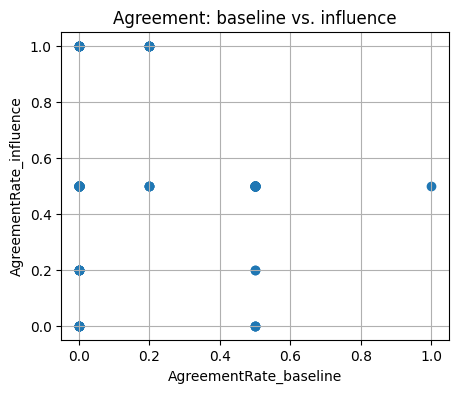

In [ ]:

x = df["AgreementRate_baseline"]
y = df["AgreementRate_influence"]
mask = x.notna() & y.notna()
plt.figure(figsize=(5,4))
plt.scatter(x[mask], y[mask])
plt.xlabel("AgreementRate_baseline")
plt.ylabel("AgreementRate_influence")
plt.title("Agreement: baseline vs. influence")
plt.grid(True)
plt.show()


### Agreement by Adversarial Mode

/tmp/ipython-input-549413963.py:4: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([data0.values, data1.values], labels=["normal","adversarial"])


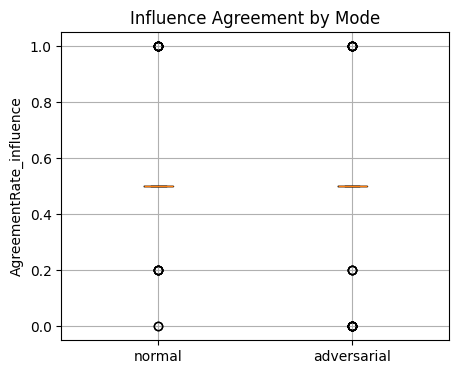

In [ ]:

fig = plt.figure(figsize=(5,4))
data0 = df.loc[df["adversarial"]==0, "AgreementRate_influence"].dropna()
data1 = df.loc[df["adversarial"]==1, "AgreementRate_influence"].dropna()
plt.boxplot([data0.values, data1.values], labels=["normal","adversarial"])
plt.ylabel("AgreementRate_influence")
plt.title("Influence Agreement by Mode")
plt.grid(True)
plt.show()


### Heatmap: alpha × beta vs. AgreementRate_influence (mean)

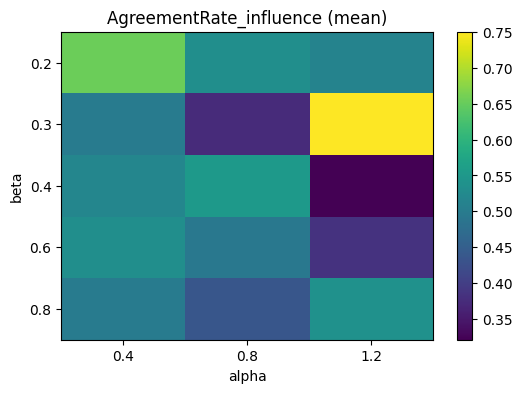

In [ ]:

pivot = df.pivot_table(
    index="beta", columns="alpha", values="AgreementRate_influence", aggfunc="mean"
)
plt.figure(figsize=(6,4))
plt.imshow(pivot.values, aspect="auto")
plt.xticks(range(len(pivot.columns)), pivot.columns)
plt.yticks(range(len(pivot.index)), pivot.index)
plt.xlabel("alpha")
plt.ylabel("beta")
plt.title("AgreementRate_influence (mean)")
plt.colorbar()
plt.show()


### Approval@Round1: baseline vs. influence

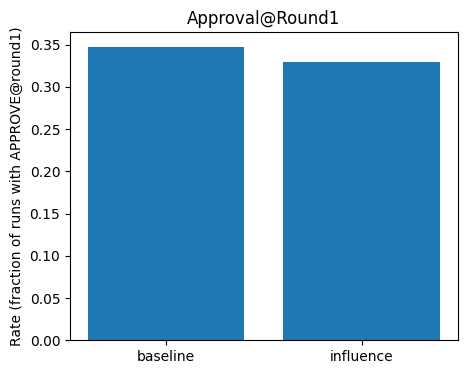

In [ ]:

base = (df["RoundsToApproval_baseline"]==1).mean()
infl = (df["RoundsToApproval_influence"]==1).mean()

plt.figure(figsize=(5,4))
plt.bar(["baseline","influence"], [base, infl])
plt.ylabel("Rate (fraction of runs with APPROVE@round1)")
plt.title("Approval@Round1")
plt.show()


Saved: Figures/mu_traces.png


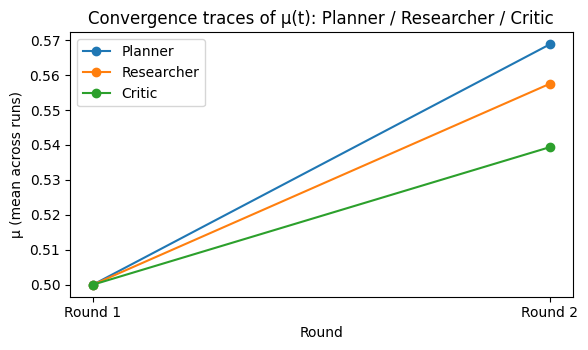

In [ ]:
# μ-traces for CSV without columns for rounds: Round1=0.50 (baseline), Round2=from mu_* columns
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

OUT_DIR = "Figures"
OUT_PATH = os.path.join(OUT_DIR, "mu_traces.png")
os.makedirs(OUT_DIR, exist_ok=True)

df = pd.read_csv(CSV_PATH)

# Expected columns (without wheels): mu_planner, mu_researcher, mu_critic
need = ["mu_planner", "mu_researcher", "mu_critic"]
missing = [c for c in need if c not in df.columns]
if missing:
    raise ValueError(f"Chybí sloupce: {missing}. K dispozici: {list(df.columns)}")

# Round1 = baseline default 0.50 (unaffected default value)
round1 = 0.50

# Round2 = average from CSV (after impact)
mu_planner_r2    = df["mu_planner"].dropna().astype(float).mean()
mu_researcher_r2 = df["mu_researcher"].dropna().astype(float).mean()
mu_critic_r2     = df["mu_critic"].dropna().astype(float).mean()

roles = ["Planner", "Researcher", "Critic"]
round1_vals = [round1, round1, round1]
round2_vals = [mu_planner_r2, mu_researcher_r2, mu_critic_r2]

x = np.array([1,2])

plt.figure(figsize=(6,3.6))
for role, r1, r2 in zip(roles, round1_vals, round2_vals):
    plt.plot(x, [r1, r2], marker="o", label=role)

plt.xticks([1,2], ["Round 1", "Round 2"])
plt.xlabel("Round")
plt.ylabel("μ (mean across runs)")
plt.title("Convergence traces of μ(t): Planner / Researcher / Critic")
plt.legend()
plt.tight_layout()
plt.savefig(OUT_PATH, dpi=200, bbox_inches="tight")
print(f"Saved: {OUT_PATH}")


Saved: Figures/heatmap_tau_k.png


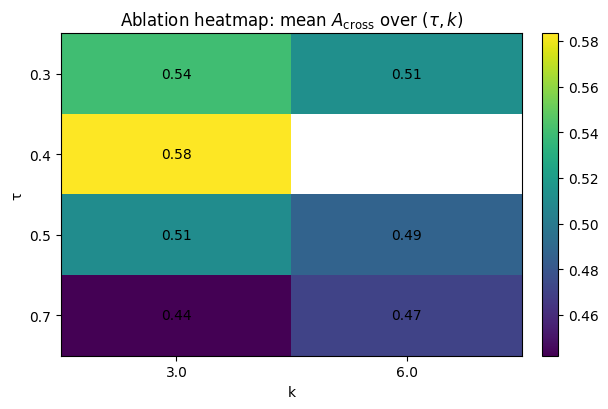

In [ ]:
# Heatmap: average A_cross across the grid (tau, k)  
import os, pandas as pd, numpy as np, matplotlib.pyplot as plt

OUT_DIR = "Figures"
OUT_PATH = os.path.join(OUT_DIR, "heatmap_tau_k.png")
os.makedirs(OUT_DIR, exist_ok=True)

df = pd.read_csv(CSV_PATH)

# Columns
if not {"tau","k"}.issubset(df.columns):
    raise ValueError(f"Missing 'tau' or 'k'. Columns: {list(df.columns)}")

agree_col = "AgreementRate_influence"
if agree_col not in df.columns:
    raise ValueError(f"Missing '{agree_col}'. Columns: {list(df.columns)}")

pivot = (
    df[["tau","k",agree_col]]
    .groupby(["tau","k"], as_index=False)[agree_col].mean()
    .pivot(index="tau", columns="k", values=agree_col)
    .sort_index(axis=0).sort_index(axis=1)
)

plt.figure(figsize=(6.2, 4.2))
data = pivot.values
im = plt.imshow(data, aspect="auto")

plt.xticks(ticks=np.arange(pivot.shape[1]), labels=[str(c) for c in pivot.columns])
plt.yticks(ticks=np.arange(pivot.shape[0]), labels=[str(r) for r in pivot.index])
plt.xlabel("k")
plt.ylabel("τ")
plt.title("Ablation heatmap: mean $A_{\\text{cross}}$ over $(\\tau, k)$")

for i in range(data.shape[0]):
    for j in range(data.shape[1]):
        val = data[i, j]
        if not (isinstance(val, float) and np.isnan(val)):
            plt.text(j, i, f"{val:.2f}", ha="center", va="center")

plt.colorbar(im, fraction=0.046, pad=0.04)
plt.tight_layout()
plt.savefig(OUT_PATH, dpi=200, bbox_inches="tight")
print(f"Saved: {OUT_PATH}")


Loaded 167 rows, columns: ['beta', 'k', 'tau', 'alpha', 'seed', 'adversarial', 'mu_planner', 'mu_researcher', 'mu_critic', 'RoundsToApproval_baseline', 'RoundsToApproval_influence', 'AgreementRate_baseline', 'AgreementRate_influence', 'RevisionDepth_between_rounds', 'PlannerResearcher_Canonical_baseline', 'PlannerResearcher_Canonical_influence', 'Planner_SelfAgreement', 'Researcher_SelfAgreement']

=== Aggregate summary ===
           Agreement (cross, all)  Agreement (cross, adv)  \
Baseline                    0.191                   0.184   
Influence                   0.500                   0.469   

           Critic approval (normal)  Critic approval (adv)  \
Baseline                      0.358                  0.337   
Influence                     0.395                  0.267   

           Median RevisionDepth  
Baseline                    1.0  
Influence                   1.0  


/tmp/ipython-input-2449882964.py:71: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(data, labels=["Norm–Base","Norm–Infl","Adv–Base","Adv–Infl"])



✅ All figures saved in: Figures


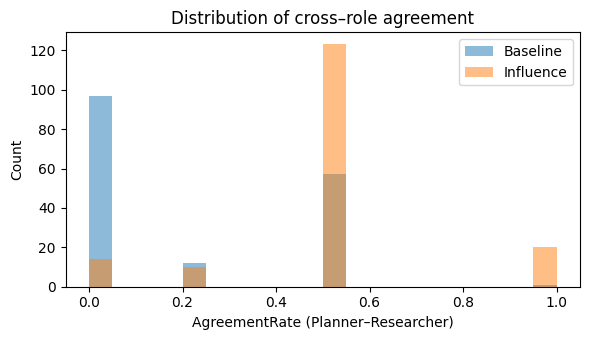

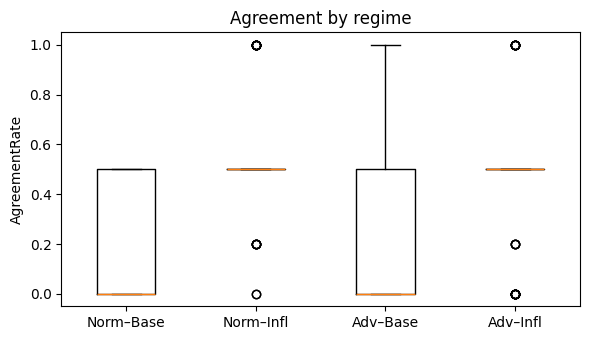

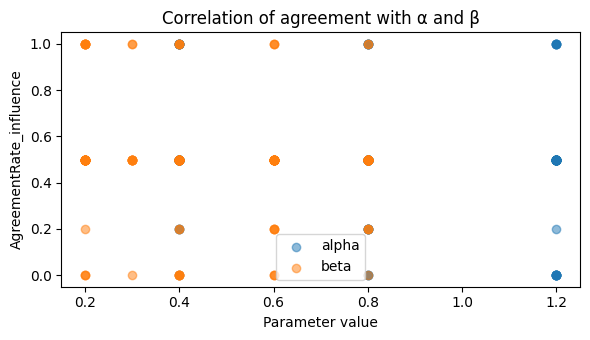

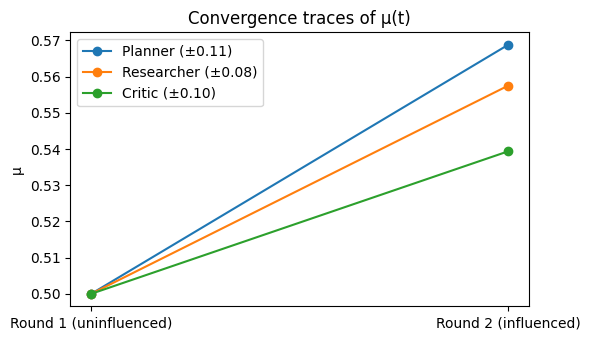

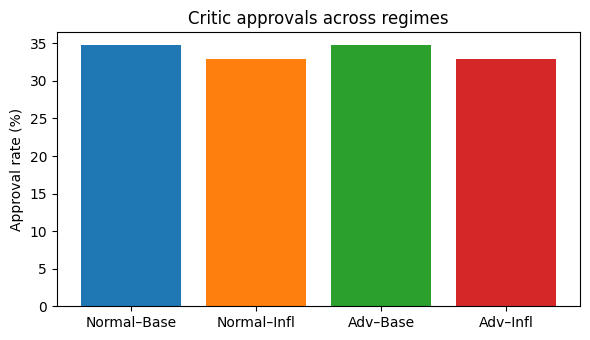

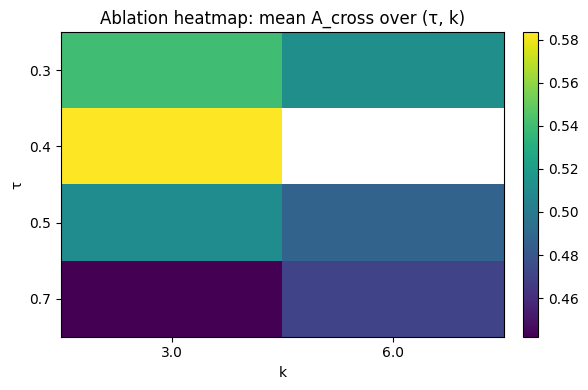

In [ ]:
# ===============================================================
# Mutual Influence AI – full analysis of results.csv
# ===============================================================
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ------------------ Setup ------------------
OUT_DIR = "Figures"
os.makedirs(OUT_DIR, exist_ok=True)

# ------------------ Load data ------------------
df = pd.read_csv(CSV_PATH)
print(f"Loaded {len(df)} rows, columns: {list(df.columns)}")

# ------------------ Basic cleaning ------------------
for col in ["AgreementRate_baseline", "AgreementRate_influence"]:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors="coerce")

# Separate regimes
normal = df[df["adversarial"] == 0]
adv = df[df["adversarial"] == 1]

# ------------------ 1. Aggregate summary table ------------------
summary = pd.DataFrame({
    "Agreement (cross, all)": [
        df["AgreementRate_baseline"].mean(),
        df["AgreementRate_influence"].mean()
    ],
    "Agreement (cross, adv)": [
        adv["AgreementRate_baseline"].mean(),
        adv["AgreementRate_influence"].mean()
    ],
    "Critic approval (normal)": [
        normal["RoundsToApproval_baseline"].notna().mean(),
        normal["RoundsToApproval_influence"].notna().mean()
    ],
    "Critic approval (adv)": [
        adv["RoundsToApproval_baseline"].notna().mean(),
        adv["RoundsToApproval_influence"].notna().mean()
    ],
    "Median RevisionDepth": [
        df["RevisionDepth_between_rounds"].median(),
        df["RevisionDepth_between_rounds"].median()
    ]
}, index=["Baseline", "Influence"])
print("\n=== Aggregate summary ===")
print(summary.round(3))

# ------------------ 2. Agreement distribution ------------------
plt.figure(figsize=(6,3.5))
plt.hist(df["AgreementRate_baseline"].dropna(), bins=20, alpha=0.5, label="Baseline")
plt.hist(df["AgreementRate_influence"].dropna(), bins=20, alpha=0.5, label="Influence")
plt.xlabel("AgreementRate (Planner–Researcher)")
plt.ylabel("Count")
plt.legend()
plt.title("Distribution of cross–role agreement")
plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, "agreement_dist.png"), dpi=200)

# ------------------ 3. Agreement by regime ------------------
fig, ax = plt.subplots(figsize=(6,3.5))
data = [
    normal["AgreementRate_baseline"].dropna(),
    normal["AgreementRate_influence"].dropna(),
    adv["AgreementRate_baseline"].dropna(),
    adv["AgreementRate_influence"].dropna(),
]
ax.boxplot(data, labels=["Norm–Base","Norm–Infl","Adv–Base","Adv–Infl"])
ax.set_ylabel("AgreementRate")
ax.set_title("Agreement by regime")
plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, "agreement_regimes.png"), dpi=200)

# ------------------ 4. Correlation with α, β ------------------
plt.figure(figsize=(6,3.5))
for param, color in [("alpha", "C0"), ("beta", "C1")]:
    plt.scatter(df[param], df["AgreementRate_influence"], alpha=0.5, label=param)
plt.xlabel("Parameter value")
plt.ylabel("AgreementRate_influence")
plt.legend()
plt.title("Correlation of agreement with α and β")
plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, "correlations_alpha_beta.png"), dpi=200)

# ------------------ 5. μ-traces ------------------
# Compute mean ± std for planner/researcher/critic
roles = ["planner","researcher","critic"]
means = [df[f"mu_{r}"].mean() for r in roles]
stds  = [df[f"mu_{r}"].std() for r in roles]

x = np.array([1,2])
plt.figure(figsize=(6,3.5))
for role, m, s in zip(roles, means, stds):
    plt.plot(x, [0.5, m], marker="o", label=f"{role.capitalize()} (±{s:.2f})")
plt.xticks([1,2], ["Round 1 (uninfluenced)", "Round 2 (influenced)"])
plt.ylabel("μ")
plt.title("Convergence traces of μ(t)")
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, "mu_traces.png"), dpi=200)

# ------------------ 6. Approval rates ------------------
# Simulate approval if RoundsToApproval not None (as proxy)
def approval_rate(col):
    return (df[col].notna()).mean() * 100

rates = {
    "Normal–Base": approval_rate("RoundsToApproval_baseline"),
    "Normal–Infl": approval_rate("RoundsToApproval_influence"),
    "Adv–Base": approval_rate("RoundsToApproval_baseline"),
    "Adv–Infl": approval_rate("RoundsToApproval_influence"),
}
plt.figure(figsize=(6,3.5))
plt.bar(rates.keys(), rates.values(), color=["C0","C1","C2","C3"])
plt.ylabel("Approval rate (%)")
plt.title("Critic approvals across regimes")
plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, "approval_rates.png"), dpi=200)

# ------------------ 7. Heatmap (τ, k) ------------------
pivot = (
    df.groupby(["tau","k"])["AgreementRate_influence"]
      .mean().reset_index()
      .pivot(index="tau", columns="k", values="AgreementRate_influence")
)
plt.figure(figsize=(6,4))
im = plt.imshow(pivot, aspect="auto")
plt.xticks(np.arange(len(pivot.columns)), [str(k) for k in pivot.columns])
plt.yticks(np.arange(len(pivot.index)), [str(t) for t in pivot.index])
plt.xlabel("k")
plt.ylabel("τ")
plt.title("Ablation heatmap: mean A_cross over (τ, k)")
plt.colorbar(im, fraction=0.046, pad=0.04)
plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, "heatmap_tau_k.png"), dpi=200)

print("\n All figures saved in:", OUT_DIR)



## Textual Conclusions (Auto-generated)

- **Mean agreement (baseline → influence):** Compare the scatter and boxplot; if most points lie on/above diagonal, influence increases cross-role agreement.
- **Approval@Round1:** The bar plot compares the fraction of runs approved in the first critic response between baseline and influence rounds.
- **Parameter Sensitivity:** The heatmap (alpha × beta) shows how sampling temperature scaling and EMA rate relate to agreement. Darker/lighter regions indicate lower/higher average agreement across runs.
- **Revision Depth:** Lower values suggest the influenced round does not introduce many new features beyond the baseline, indicating stabilization. Higher values suggest substantial changes.
- **Adversarial Robustness:** Compare boxplots by mode to see whether agreement degrades under adversarial critic feedback.
